In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot

# Custom libraries
import utils as lu

In [2]:
# Reload modules in case of modifications
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/figures0/utils.py'>

# Data directories

In [3]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'

In [4]:
# Specify directories and relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Select adhesome loci

In [5]:
# Load adhesome components data
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = lu.load_adhesome_data(adhesome_components_filename)
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_gene_locations(gene_locations_filename, gene_id_filename)
# Find location of adhesome genes
adhesome_loc_df, missing_adhesome_genes = lu.get_adhesome_genes_location(df_components, df_loc)
adhesome_loc_df = lu.get_adhesome_genes_loci(adhesome_loc_df, resol)
adhesome_loc_df['chrom_int'] = adhesome_loc_df['chrom'].str.split('chr').str[1].astype(int)
adhesome_genes = np.unique(adhesome_loc_df['gene'])
print('Final number of adhesome genes = '+str(len(adhesome_genes)))
# Construct data frame annotating each adhesome locus with gene
adhesome_chr_loci = adhesome_loc_df[['chrom','chrom_int','loci','gene']]
adhesome_chr_loci = adhesome_chr_loci.sort_values(['chrom_int','loci'])
adhesome_loci = [adhesome_chr_loci.iloc[i]['chrom']+'_'+'loc'+str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                 for i in range(len(adhesome_chr_loci))]
# Add locus ID column
adhesome_chr_loci['locus_id'] = ['chr_'+str(adhesome_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(adhesome_chr_loci))]
# Visualize head of adhesome_chr_loci
print('Number of adhesome loci = '+str(len(adhesome_loci)))
adhesome_chr_loci.head()

Adhesome genes absent from UCSC genes: ['DDEF1', 'GRLF1', 'PPP2CA', 'SMPX', 'SH3KBP1', 'FLNA', 'MSN', 'ITGAW', 'ARHGEF6', 'JUB']
Final number of adhesome genes = 222
Number of adhesome loci = 305


,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,64,FBLIM1,chr_1_loc_16000000
97,chr1,1,95,ASAP3,chr_1_loc_23750000
173,chr1,1,109,SLC9A1,chr_1_loc_27250000
158,chr1,1,127,FABP3,chr_1_loc_31750000
139,chr1,1,158,MACF1,chr_1_loc_39500000


In [6]:
# Save adhesome loci dataframe to pickle
pickle.dump(adhesome_chr_loci, open('../epigenome_processing/adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# List of all adhesome genes
all_adhesome_genes = np.unique(adhesome_chr_loci['gene'].values)

# Select only active loci

In [8]:
# Load annotated loci across all genome
df_clusters = pickle.load(open(processed_epigenome_data_dir+'active_inactive_loci.pkl', 'rb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-33.709240,36.526043,0
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-48.529285,25.357332,0
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-28.440704,33.148647,0
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-60.775291,-49.806629,0
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-57.881870,-49.496571,0


In [9]:
# All loci
all_loci = set(df_clusters.index)
print('Total number of loci = '+str(len(all_loci)))

Total number of loci = 11537


In [10]:
# Active loci correspond to cluster 1
active_loci = list(df_clusters[df_clusters['cluster']==1].index)
print('Number of active loci: '+str(len(active_loci)))
# Inactive loci correspond to cluster 0
inactive_loci = list(df_clusters[df_clusters['cluster']==0].index)
print('Number of inactive loci: '+str(len(inactive_loci)))

Number of active loci: 6452
Number of inactive loci: 5085


In [11]:
# Dictionary of active loci for each chromosome
active_loci_dict = dict()
for chrom in range(1,22+1):
    active_loci_dict[chrom] = ([int(s.split('_')[3]) for s in active_loci if 'chr_'+str(chrom)+'_' in s])

# Study active and inactive adhesome loci

### Active/inactive loci per chromosome

In [12]:
# Add activity column to adhesome_chr_loci
adhesome_chr_loci['active'] = [adhesome_chr_loci.iloc[i]['locus_id'] in active_loci 
                               for i in range(len(adhesome_chr_loci))]
adhesome_chr_loci.to_csv('adhesome_loci_activity.csv', header=True)
# Unique adhesome loci
adhesome_chr_loci_unique = adhesome_chr_loci.drop_duplicates(subset='locus_id')
adhesome_loci_list = adhesome_chr_loci_unique['locus_id'].tolist()

Number of active adhesome loci = 281
Number of inactive adhesome loci = 16


<Figure size 432x288 with 0 Axes>

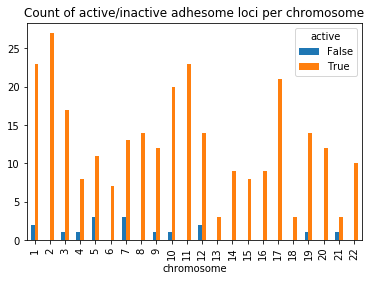

In [13]:
# Basic statistics
print('Number of active adhesome loci = '+str(len(adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==True]['locus_id'])))
print('Number of inactive adhesome loci = '+str(len(adhesome_chr_loci_unique[adhesome_chr_loci_unique['active']==False]['locus_id'])))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci_unique.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='Count of active/inactive adhesome loci per chromosome')
plt.xlabel('chromosome')
plt.show()

### Select 4 groups of loci

In [14]:
# Load pickled loci
active_adhesome_loci, inactive_adhesome_loci, random_active_non_adhesome_loci, random_inactive_non_adhesome_loci = pickle.load(open('adh_and_random_loci.pkl', 'rb'))

# Create list out of all four groups of loci
loci_list = list(itertools.chain.from_iterable([active_adhesome_loci,
                                                inactive_adhesome_loci,
                                                random_active_non_adhesome_loci,
                                                random_inactive_non_adhesome_loci]))

FileNotFoundError: [Errno 2] No such file or directory: 'adh_and_random_loci.pkl'

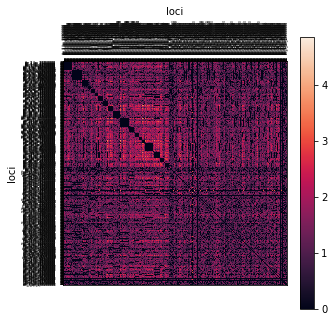

In [15]:
# Load contacts_df1
contacts_df1 = pickle.load(open('contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
lu.plot_heatmap(contacts_df1, 
                loci_list, loci_list,
                'loci', 'loci', 
                5, contacts_df1.max().max())

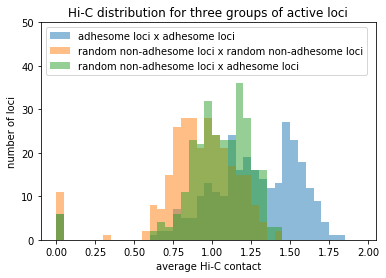

In [16]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].mean()
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci].mean()
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = contacts_df1.loc[random_active_non_adhesome_loci,active_adhesome_loci].mean()
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_active, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,50)
plt.legend(loc='upper left')
plt.show()

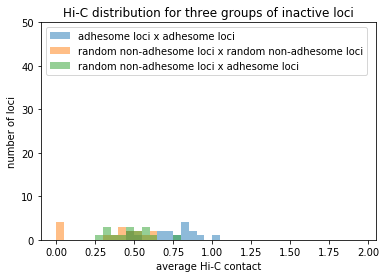

In [17]:
# Histogram of average Hi-C contacts in three inactive cases
# Group of inactive adhesome loci with itself
inactive_adhesome_hic_with_itself = contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci].mean()
# Group of random inactive non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = contacts_df1.loc[random_inactive_non_adhesome_loci,random_inactive_non_adhesome_loci].mean()
# Group of random inactive non-adhesome loci with inactive adhesome loci
random_versus_adhesome_inactive = contacts_df1.loc[random_inactive_non_adhesome_loci,inactive_adhesome_loci].mean()
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_inactive, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,50)
plt.legend(loc='upper left')
plt.show()

# Graph of active loci

In [18]:
# Load pickled edge list containing edges between active loci
edge_list = pickle.load(open('edge_list.pkl', 'rb'))
edge_list.head(3)

,locus1,locus2,hic_contact
0,chr_1_loc_750000,chr_2_loc_0,1.473464
4,chr_1_loc_750000,chr_2_loc_1500000,2.028817
7,chr_1_loc_750000,chr_2_loc_3250000,1.794648


DescribeResult(nobs=14992782, minmax=(0.44004094692730095, 7.5364672416389995), mean=1.2284616137501867, variance=0.21439608064705115, skewness=0.5631200415310013, kurtosis=0.1666007519747441)


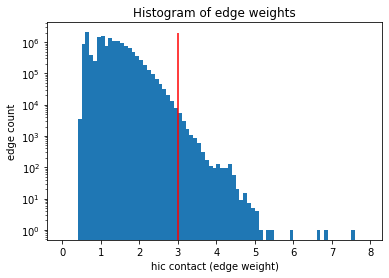

In [19]:
# Plot histogram of edge weights (Hi-C contact values) between active loci
print(ss.describe(edge_list['hic_contact']))
plt.figure()
plt.hist(edge_list['hic_contact'],bins=np.arange(0,8,0.1))
plt.vlines(3, ymin=0, ymax=2000000, color='red')
plt.xlabel('hic contact (edge weight)')
plt.ylabel('edge count')
plt.yscale('log')
plt.title('Histogram of edge weights')
plt.show()

In [20]:
# Load pickled lists used to choose the edge Hi-C threshold
number_nodes,number_adhesome_nodes,number_edges,average_node_degree = pickle.load(open('edge_threshold_choice.pkl', 'rb'))

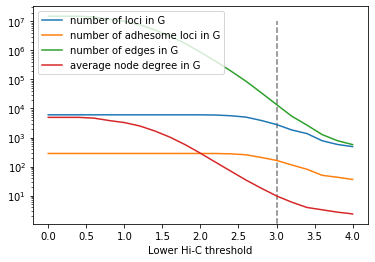

In [21]:
# Plot the different curves
range_threshold = np.arange(0,4.2,0.2)
plt.figure()
plt.plot(range_threshold, number_nodes, label='number of loci in G')
plt.plot(range_threshold, number_adhesome_nodes, label='number of adhesome loci in G')
plt.plot(range_threshold, number_edges, label='number of edges in G')
plt.plot(range_threshold, average_node_degree, label='average node degree in G')
plt.vlines(3, ymin=0, ymax=1e7, color='grey', linestyle='dashed')
plt.xlabel('Lower Hi-C threshold')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

In [22]:
# Using the above plot, pick threshold to obtain final edge_list
t = 3
edge_list_final = edge_list[edge_list['hic_contact']>t]
print('Total number of edges = '+str(len(edge_list_final)))

Total number of edges = 13682


Total number of nodes in G = 2800
Number of active adhesome nodes in G = 160
Total number of edges in G = 13682
Average node degree in G = 9.772857142857143
Number of connected components in G = 9
Size of connected components = [2782, 2, 2, 3, 2, 2, 3, 2, 2]


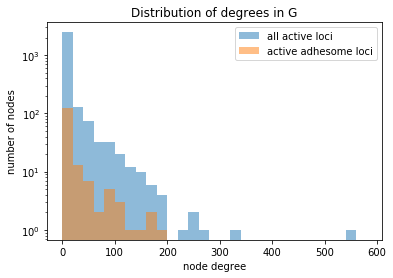

In [23]:
# Create graph from edge list
G = nx.from_pandas_edgelist(edge_list_final, 'locus1', 'locus2', ['hic_contact'])
print('Total number of nodes in G = '+str(len(G.nodes)))
print('Number of active adhesome nodes in G = '+str(len(set(active_adhesome_loci).intersection(set(G.nodes)))))
print('Total number of edges in G = '+str(len(G.edges)))
print('Average node degree in G = '+str(np.mean(list(dict(G.degree).values()))))
print('Number of connected components in G = '+str(nx.number_connected_components(G)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(G)]))
#pickle.dump(G, open(prelim_results_dir+'interX_hic_network.pkl', 'wb'))
plt.figure()
plt.hist(dict(G.degree()).values(), bins=np.arange(0,600,20), 
         alpha=0.5, label='all active loci')
plt.hist(dict(G.degree(adhesome_loci_list)).values(), bins=np.arange(0,600,20), 
         alpha=0.5, label='active adhesome loci')
plt.title('Distribution of degrees in G')
plt.yscale('log')
plt.xlabel('node degree')
plt.ylabel('number of nodes')
plt.legend()
plt.show()

# Analyze network degrees

In [24]:
# Select loci that have a degree higher than 200
high_degree_loci = [locus for locus in dict(G.degree()).keys() if dict(G.degree())[locus]>50]
print('Number of high degree loci = '+str(len(high_degree_loci)))

Number of high degree loci = 153


<Figure size 432x288 with 0 Axes>

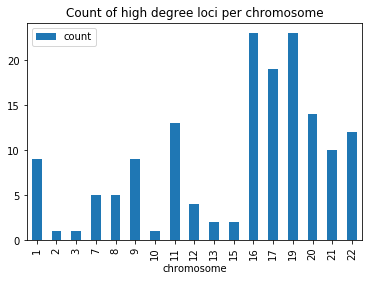

In [25]:
# See on what chromosomes these loci are
high_degree_chroms = [locus.split('_')[1] for locus in high_degree_loci]
table = np.unique(high_degree_chroms, axis=0, return_counts=True)
table_df = pd.DataFrame({'chr': table[0].astype(int), 'count': table[1]}).set_index('chr').sort_index()
plt.figure()
table_df.plot(kind='bar', title='Count of high degree loci per chromosome')
plt.xlabel('chromosome')
plt.show()

In [26]:
# Relative position of adhesome loci
df_sizes = lu.get_chrom_sizes(dir_genome,resol).set_index('chr')
adhesome_loci_in_graph = [locus for locus in adhesome_chr_loci['locus_id'].tolist() if locus in G.nodes]
adhesome_loc = [int(locus.split('_')[3])/df_sizes.loc[locus.split('_')[1]]['size']
                  for locus in adhesome_loci_in_graph]

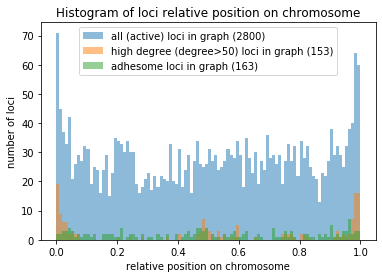

In [27]:
# Location of high degree nodes on chromosome
all_degree_loc = [int(locus.split('_')[3])/df_sizes.loc[locus.split('_')[1]]['size']
                  for locus in dict(G.degree()).keys()]
high_degree_loc = [int(locus.split('_')[3])/df_sizes.loc[locus.split('_')[1]]['size']
                  for locus in high_degree_loci]
plt.figure()
plt.hist(all_degree_loc, bins=np.arange(0,1.01,0.01), alpha=0.5, label='all (active) loci in graph (2800)')
plt.hist(high_degree_loc, bins=np.arange(0,1.01,0.01), alpha=0.5, label='high degree (degree>50) loci in graph (153)')
plt.hist(adhesome_loc, bins=np.arange(0,1.01,0.01), alpha=0.5, label='adhesome loci in graph (163)')
plt.xlabel('relative position on chromosome')
plt.ylabel('number of loci')
plt.title('Histogram of loci relative position on chromosome')
plt.legend()
plt.show()

In [28]:
# Location of blacklisted loci 
blacklisted_loci_dict = pickle.load(open(dir_processed_hic+'blacklist.pickle', 'rb'))
blacklisted_loci_list = list(itertools.chain.from_iterable([['chr_'+str(chrom)+'_loc_'+str(list(blacklisted_loci_dict[chrom])[i]) 
                          for i in range(len(blacklisted_loci_dict[chrom]))] 
                         for chrom in np.arange(1,22+1,1)]))
non_blacklisted_loci_list = list(set(all_loci)-set(blacklisted_loci_list))
len(non_blacklisted_loci_list)

9714

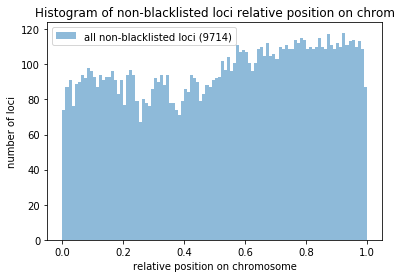

In [29]:
# Location of non-blacklisted loci on chromosome
non_blacklisted_loc = [int(locus.split('_')[3])/df_sizes.loc[locus.split('_')[1]]['size']
                  for locus in non_blacklisted_loci_list]
plt.figure()
plt.hist(non_blacklisted_loc, bins=np.arange(0,1.01,0.01), alpha=0.5, label='all non-blacklisted loci (9714)')
plt.xlabel('relative position on chromosome')
plt.ylabel('number of loci')
plt.title('Histogram of non-blacklisted loci relative position on chrom')
plt.legend()
plt.show()

In [30]:
# Analyze position of centromeres on chromosomes
centrom_filename = dir_genome+'chrom_hg19.centromeres'
df_centrom = pd.read_csv(centrom_filename, sep = '\t')
df_centrom['centrom_middle'] = (df_centrom['chromStart']+df_centrom['chromEnd'])/2
centrom_loc = [df_centrom.iloc[i]['centrom_middle']/df_sizes.loc[df_centrom.iloc[i]['chrom'].split('chr')[1]]['size']
                  for i in range(len(df_centrom))]

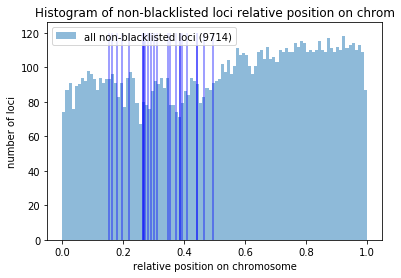

In [31]:
# Location of blacklisted loci on chromosome
non_blacklisted_loc = [int(locus.split('_')[3])/df_sizes.loc[locus.split('_')[1]]['size']
                  for locus in non_blacklisted_loci_list]
plt.figure()
plt.hist(non_blacklisted_loc, bins=np.arange(0,1.01,0.01), alpha=0.5, label='all non-blacklisted loci (9714)')
for i in range(len(centrom_loc)):
    plt.vlines(x=centrom_loc[i], ymin=0, ymax=120, color='blue', alpha=0.5)
plt.xlabel('relative position on chromosome')
plt.ylabel('number of loci')
plt.title('Histogram of non-blacklisted loci relative position on chrom')
plt.legend()
plt.show()

# Analyze network genes

In [32]:
# Load all TF genes (using TRRUST)
tf_df0 = pickle.load(open(dir_genome+'trrust_df.pkl', 'rb'))
all_tf_genes = np.unique(tf_df0['TF'].values)
all_tf_genes

array(['AATF', 'ABL1', 'AES', 'AHR', 'AIP', 'AIRE', 'ANKRD1', 'APBB1',
       'APC', 'APEX1', 'AR', 'ARID1A', 'ARID1B', 'ARID3A', 'ARNT',
       'ARNTL', 'ARNTL2', 'ARX', 'ASCL1', 'ASH1L', 'ASXL1', 'ATF1',
       'ATF2', 'ATF3', 'ATF4', 'ATF5', 'ATF6', 'ATF7', 'ATM', 'ATOH1',
       'ATRX', 'BACH1', 'BACH2', 'BARD1', 'BARX2', 'BATF', 'BCL11A',
       'BCL3', 'BCL6', 'BDP1', 'BHLHE41', 'BIN1', 'BMI1', 'BPTF', 'BRCA1',
       'BRCA2', 'BRD7', 'BRIP1', 'BRPF1', 'BTAF1', 'BTF3', 'BTG2',
       'CBFA2T3', 'CBFB', 'CBX7', 'CBX8', 'CDC5L', 'CDCA7L', 'CDX1',
       'CDX2', 'CEBPA', 'CEBPB', 'CEBPD', 'CEBPE', 'CEBPG', 'CEBPZ',
       'CHD4', 'CHD8', 'CIITA', 'CITED2', 'CLOCK', 'CNBP', 'CNOT7',
       'CNOT8', 'COPS5', 'CRABP2', 'CREB1', 'CREB3', 'CREB3L1', 'CREB3L4',
       'CREB5', 'CREBBP', 'CREG1', 'CREM', 'CRTC1', 'CRX', 'CTBP1',
       'CTCF', 'CTCFL', 'CTNNB1', 'CTNNBIP1', 'CUX1', 'DACH1', 'DAXX',
       'DBP', 'DDB1', 'DDB2', 'DDIT3', 'DDX5', 'DEAF1', 'DEDD', 'DEK',
       'DENND4A', 'DL

In [33]:
# For each locus, also express it by the corresponding genes
adhesome_gene_id_ls = []
tf_gene_id_ls = []
locus_gene_list = []
locus_adhesome_gene_list = []
locus_tf_gene_list = []
for locus in tqdm(list(G.nodes)):
    time.sleep(.01)
    # Select chromosome
    chrom = 'chr'+locus.split('_')[1]
    df_loc_chrom = df_loc[df_loc['#chrom']==chrom]
    # Find genes and create gene ID for the locus
    loc = int(locus.split('_')[3])
    genes0 = df_loc_chrom.loc[(df_loc_chrom['chromStart']//resol)*resol == loc,'geneSymbol'].values
    genes1 = df_loc_chrom.loc[(df_loc_chrom['chromEnd']//resol)*resol == loc,'geneSymbol'].values
    genes2 = df_loc_chrom.loc[((df_loc_chrom['chromStart']//resol)*resol < loc) & 
                             ((df_loc_chrom['chromEnd']//resol)*resol > loc),'geneSymbol'].values
    genes = np.unique(list(itertools.chain.from_iterable([genes0,genes1,genes2])))
    adhesome_genes = [gene for gene in genes if gene in all_adhesome_genes]
    tf_genes = [gene for gene in genes if gene in all_tf_genes]
    locus_gene_list.append(genes)
    locus_adhesome_gene_list.append(adhesome_genes)
    locus_tf_gene_list.append(tf_genes)
    adhesome_gene_id = ''+"_".join(adhesome_genes)
    tf_gene_id = ''+"_".join(tf_genes)
    adhesome_gene_id_ls.append(adhesome_gene_id)
    tf_gene_id_ls.append(tf_gene_id)
pickle.dump([adhesome_gene_id_ls,tf_gene_id_ls,locus_gene_list,locus_adhesome_gene_list,locus_tf_gene_list], open('locus_gene_id.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 2800/2800 [00:49<00:00, 56.02it/s]


In [34]:
# Proportion of loci with no genes
adhesome_gene_id_ls,tf_gene_id_ls,locus_gene_list,locus_adhesome_gene_list,locus_tf_gene_list = pickle.load(open('locus_gene_id.pkl', 'rb'))
print('Number of loci in G = '+str(len(G.nodes)))
print('Proportion of loci with no genes = '+str(sum(np.array([len(gene_ls) for gene_ls in locus_gene_list])==0)/len(np.array(adhesome_gene_id_ls))))

Number of loci in G = 2800
Proportion of loci with no genes = 0.023928571428571428


In [35]:
# Dataframe of nodes in G
node_attributes = pd.DataFrame({'locus_id': list(G.nodes),
                                'adhesome_gene_id': adhesome_gene_id_ls,
                                'tf_gene_id': tf_gene_id_ls,
                                'locus_gene_list': locus_gene_list,
                                'locus_adhesome_gene_list': locus_adhesome_gene_list,
                                'locus_tf_gene_list': locus_tf_gene_list,
                                'has_genes': [len(gene_ls) for gene_ls in locus_gene_list],
                                'has_adhesome_genes': [len(gene_ls) for gene_ls in locus_adhesome_gene_list],
                                'has_tf_genes': [len(gene_ls) for gene_ls in locus_tf_gene_list]})
node_attributes.head()

,locus_id,adhesome_gene_id,tf_gene_id,locus_gene_list,locus_adhesome_gene_list,locus_tf_gene_list,has_genes,has_adhesome_genes,has_tf_genes
0,chr_1_loc_750000,,,"[AGRN, AK056486, BC033949, C1ORF170, FAM41C, H...",[],[],14,0,0
1,chr_2_loc_242500000,,,"[AK126180, ATG4B, BOK, D2HGDH, DTYMK, GAL3ST2,...",[],[],9,0,0
2,chr_2_loc_242750000,,,"[AK097934, BC101234, CXXC11, NEU4, PABL, PDCD1]",[],[],6,0,0
3,chr_1_loc_1000000,,,"[ACAP3, AK128833, B3GALT6, BC033949, C1ORF159,...",[],[],21,0,0
4,chr_2_loc_219000000,ARPC2,,"[AAMP, ARPC2, BC038211, C2ORF62, CXCR1, CXCR2,...",[ARPC2],[],11,1,0


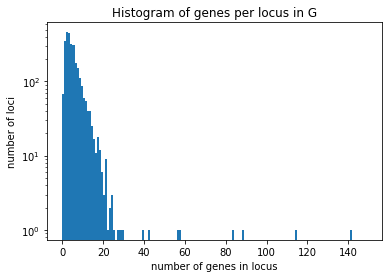

(array([0, 1, 2]), array([2640,  157,    3]))


In [36]:
# Histogram of number of genes per locus
plt.figure()
plt.hist(node_attributes['has_genes'], bins=np.arange(0,150,1))
plt.yscale('log')
plt.xlabel('number of genes in locus')
plt.ylabel('number of loci')
plt.title('Histogram of genes per locus in G')
plt.show()
print(np.unique(node_attributes['has_adhesome_genes'], return_counts=True))

In [37]:
# List loci in G that have at least one gene
loci_with_genes = node_attributes[node_attributes['has_genes']>0]['locus_id'].values
print('Number of loci with gene in G = '+str(len(loci_with_genes)))

Number of loci with gene in G = 2733


Total number of nodes in G1 = 2733
Number of active adhesome nodes in G1 = 160
Total number of edges in G1 = 13595
Average node degree in G1 = 9.948774240761068
Number of connected components in G1 = 9
Size of connected components = [2715, 2, 2, 3, 2, 2, 3, 2, 2]


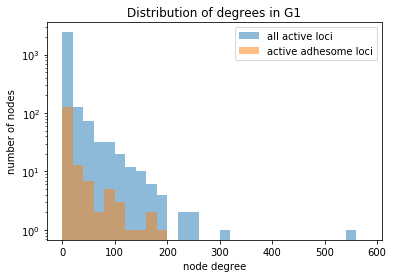

In [38]:
# Restrict G to these loci with at least one gene
G1 = G.subgraph(loci_with_genes)
print('Total number of nodes in G1 = '+str(len(G1.nodes)))
print('Number of active adhesome nodes in G1 = '+str(len(set(active_adhesome_loci).intersection(set(G1.nodes)))))
print('Total number of edges in G1 = '+str(len(G1.edges)))
print('Average node degree in G1 = '+str(np.mean(list(dict(G1.degree).values()))))
print('Number of connected components in G1 = '+str(nx.number_connected_components(G1)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(G1)]))
plt.figure()
plt.hist(dict(G1.degree()).values(), bins=np.arange(0,600,20), 
         alpha=0.5, label='all active loci')
plt.hist(dict(G1.degree(adhesome_loci_list)).values(), bins=np.arange(0,600,20), 
         alpha=0.5, label='active adhesome loci')
plt.title('Distribution of degrees in G1')
plt.yscale('log')
plt.xlabel('node degree')
plt.ylabel('number of nodes')
plt.legend()
plt.show()

In [39]:
# Deep dive into loci having many genes
node_attributes = node_attributes.sort_values(by='has_genes', ascending=False)
node_attributes['number_DQ'] = [len([gene for gene in node_attributes.iloc[i]['locus_gene_list'] if ('DQ' in gene)]) for i in range(len(node_attributes))]
node_attributes['number_SNORD'] = [len([gene for gene in node_attributes.iloc[i]['locus_gene_list'] if ('SNORD' in gene)]) for i in range(len(node_attributes))]
node_attributes['number_MIR'] = [len([gene for gene in node_attributes.iloc[i]['locus_gene_list'] if ('MIR' in gene)]) for i in range(len(node_attributes))]
node_attributes['minus_DQ_SNORD_MIR_genes'] = node_attributes['has_genes']-np.array([len([gene for gene in node_attributes.iloc[i]['locus_gene_list'] if ('DQ' in gene) or ('SNORD' in gene) or ('MIR' in gene) ]) for i in range(len(node_attributes))])
node_attributes = node_attributes.set_index('locus_id')
node_attributes.head()

,adhesome_gene_id,tf_gene_id,locus_gene_list,locus_adhesome_gene_list,locus_tf_gene_list,has_genes,has_adhesome_genes,has_tf_genes,number_DQ,number_SNORD,number_MIR,minus_DQ_SNORD_MIR_genes
locus_id,,,,,,,,,,,,
chr_6_loc_33750000,,,"[AL832447, DQ570017, DQ570026, DQ570403, DQ570...",[],[],141,0,0,135,0,1,5
chr_15_loc_62500000,,,"[DQ570033, DQ570108, DQ570129, DQ570912, DQ571...",[],[],114,0,0,113,0,0,1
chr_15_loc_51500000,,,"[CYP19A1, DMXL2, DQ570035, DQ570267, DQ570455,...",[],[],88,0,0,83,0,1,4
chr_15_loc_102250000,,,"[BC101079, DQ570882, DQ570906, DQ571326, DQ571...",[],[],83,0,0,76,0,0,7
chr_10_loc_79500000,,,"[AK125684, DLG5, DLG5-AS1, DQ570533, DQ570592,...",[],[],57,0,0,53,0,0,4


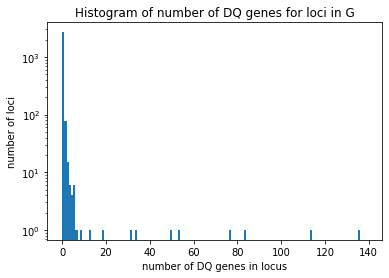

In [40]:
# Histogram of number of DQ genes per locus
plt.figure()
plt.hist(node_attributes['number_DQ'], bins=np.arange(0,140,1))
plt.yscale('log')
plt.xlabel('number of DQ genes in locus')
plt.ylabel('number of loci')
plt.title('Histogram of number of DQ genes for loci in G')
plt.show()

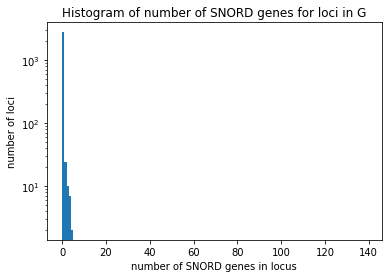

In [41]:
# Histogram of number of SNORD genes per locus
plt.figure()
plt.hist(node_attributes['number_SNORD'], bins=np.arange(0,140,1))
plt.yscale('log')
plt.xlabel('number of SNORD genes in locus')
plt.ylabel('number of loci')
plt.title('Histogram of number of SNORD genes for loci in G')
plt.show()

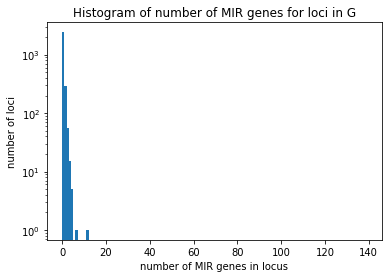

In [42]:
# Histogram of number of MIR genes per locus
plt.figure()
plt.hist(node_attributes['number_MIR'], bins=np.arange(0,140,1))
plt.yscale('log')
plt.xlabel('number of MIR genes in locus')
plt.ylabel('number of loci')
plt.title('Histogram of number of MIR genes for loci in G')
plt.show()

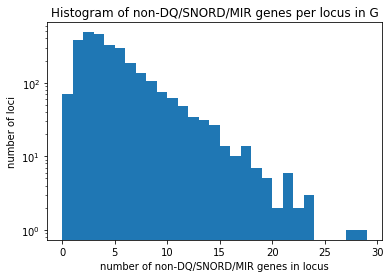

In [43]:
# Histogram of number of genes per locus after removing DQ/SNORD/MIR genes
plt.figure()
plt.hist(node_attributes['minus_DQ_SNORD_MIR_genes'], bins=np.arange(0,30,1))
plt.yscale('log')
plt.xlabel('number of non-DQ/SNORD/MIR genes in locus')
plt.ylabel('number of loci')
plt.title('Histogram of non-DQ/SNORD/MIR genes per locus in G')
plt.show()

# Steiner tree analysis

### Vary w and b

In [44]:
# Build interactome file
beta = 1
interactome_file_name = "loci_interactome.txt"
interactome_df = oi.get_networkx_graph_as_dataframe_of_edges(G1)
interactome_df['cost'] = np.exp(-beta*interactome_df['hic_contact'])/max(np.exp(-beta*interactome_df['hic_contact']))
interactome_df['normalized_hic'] = interactome_df['hic_contact']/max(interactome_df['hic_contact'])
interactome_df = interactome_df[['protein1','protein2','cost','hic_contact','normalized_hic']]
interactome_df.to_csv(interactome_file_name, sep='\t', header=True, index=False)
# Build prize file
adhesome_loci_G1 = [locus for locus in G1.nodes if (locus in active_adhesome_loci)]
prize_file_name = "adhesome_loci_prizes.tsv"
prize_df = adhesome_chr_loci_unique.copy()
prize_df = prize_df[prize_df['locus_id'].isin(adhesome_loci_G1)]
prize_df['prize'] = 10
prize_df = prize_df[prize_df['active']==True][['locus_id','prize']]
prize_df.columns = [['name','prize']]
prize_df = prize_df.drop_duplicates()
prize_df.to_csv(prize_file_name, sep='\t', header=True, index=False)
n_terminals = len(prize_df)

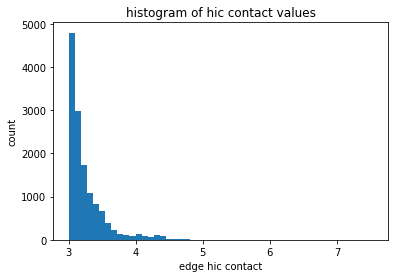

In [45]:
# Histogram of Hi-C contacts
plt.figure()
plt.hist(interactome_df['hic_contact'],50)
plt.xlabel('edge hic contact')
plt.ylabel('count')
plt.title('histogram of hic contact values')
plt.show()

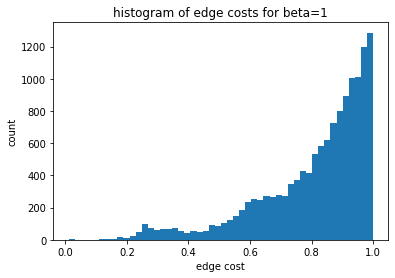

In [46]:
# Histogram of edge costs
plt.figure()
plt.hist(interactome_df['cost'],50)
plt.xlabel('edge cost')
plt.ylabel('count')
plt.title('histogram of edge costs for beta='+str(beta))
plt.show()

In [182]:
networks_summary_df = pickle.load(open('networks_summary_df.pkl', 'rb'))
networks_summary_df

,index,w,b,g,nodes,edges,number_components,size_components,percentage_terminals
w_0.2_b_10.0,0,0.2,10.0,0,160,175,93,"[68, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.0
w_0.2_b_20.0,1,0.2,20.0,0,160,175,93,"[68, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.0
w_0.2_b_30.0,2,0.2,30.0,0,160,175,93,"[68, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.0
w_0.2_b_40.0,3,0.2,40.0,0,160,175,93,"[68, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.0
w_0.2_b_50.0,4,0.2,50.0,0,160,175,93,"[68, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.0
w_0.4_b_10.0,5,0.4,10.0,0,163,223,63,"[101, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0
w_0.4_b_20.0,6,0.4,20.0,0,163,223,63,"[101, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0
w_0.4_b_30.0,7,0.4,30.0,0,163,223,63,"[101, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0
w_0.4_b_40.0,8,0.4,40.0,0,163,223,63,"[101, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0
w_0.4_b_50.0,9,0.4,50.0,0,163,223,63,"[101, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0


<Figure size 432x288 with 0 Axes>

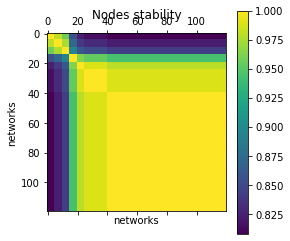

In [52]:
# Loci stability heatmap
N = len(networks_summary_df)
mat_allnodes = np.zeros((N,N))
for i in np.arange(N):
    for j in np.arange(i+1,N,1):
        # Select networks
        paramstring_a = networks_summary_df.loc[networks_summary_df['index']==i].index[0]
        paramstring_b = networks_summary_df.loc[networks_summary_df['index']==j].index[0]
        network_a = networks_dict[paramstring_a]
        network_b = networks_dict[paramstring_b]
        # Compute intersection/union
        intersection = float(len(set(network_a.nodes()).intersection(set(network_b.nodes()))))
        union = float(len(set(network_a.nodes()).union(set(network_b.nodes()))))
        mat_allnodes[i,j] = intersection/union    
mat_allnodes = mat_allnodes+np.transpose(mat_allnodes)+np.diag(np.ones(N))
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

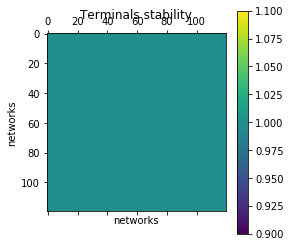

In [107]:
# Terminal stability heatmap
N = len(networks_summary_df)    
mat_terminals = np.zeros((N,N))
for i in np.arange(N):
    for j in np.arange(i+1,N,1):
        # Select networks
        paramstring_a = networks_summary_df.loc[networks_summary_df['index']==i].index[0]
        paramstring_b = networks_summary_df.loc[networks_summary_df['index']==j].index[0]
        network_a = networks_dict[paramstring_a]
        network_b = networks_dict[paramstring_b]
        # Compute intersection/union
        df_a = oi.get_networkx_graph_as_dataframe_of_nodes(network_a)
        terminals_in_a = set(df_a[df_a['terminal']==True].index)
        df_b = oi.get_networkx_graph_as_dataframe_of_nodes(network_b)
        terminals_in_b = set(df_b[df_b['terminal']==True].index)
        intersection = float(len(terminals_in_a.intersection(terminals_in_b)))
        union = float(len(terminals_in_a.union(terminals_in_b)))
        mat_terminals[i,j] = intersection/union    
mat_terminals = mat_terminals+np.transpose(mat_terminals)+np.diag(np.ones(N))
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

### Select network for w=3, b=10, g=0

In [183]:
# Summary of that selected network
networks_summary_df.loc['w_3.0000000000000004_b_10.0']

index                                   70
w                       3.0000000000000004
b                                     10.0
g                                        0
nodes                                  198
edges                                  616
number_components                        2
size_components                   [197, 1]
percentage_terminals                     1
Name: w_3.0000000000000004_b_10.0, dtype: object

In [184]:
# Select network
final_network = networks_dict['w_3.0000000000000004_b_10.0'].copy()
final_nodes = list(final_network.nodes)

In [185]:
list(nx.connected_components(final_network))[1]

{'chr_8_loc_128500000'}

In [186]:
# Add node metadata
nx.set_node_attributes(final_network, {locus: locus.split('_')[1] for locus in final_network.nodes}, 'chromosome')
nx.set_node_attributes(final_network, {locus: float(node_attributes.loc[locus,'minus_DQ_SNORD_MIR_genes']) for locus in final_network.nodes}, 'number_of_genes')
nx.set_node_attributes(final_network, {locus: float(node_attributes.loc[locus,'has_adhesome_genes']) for locus in final_network.nodes}, 'number_of_adhesome_genes')
nx.set_node_attributes(final_network, {locus: float(node_attributes.loc[locus,'has_tf_genes']) for locus in final_network.nodes}, 'number_of_tf_genes')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'has_adhesome_genes']>0) for locus in final_network.nodes}, 'has_adhesome_genes')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'has_tf_genes']>0) for locus in final_network.nodes}, 'has_tf_genes')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'adhesome_gene_id']) for locus in final_network.nodes}, 'adhesome_gene_name')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'tf_gene_id']) for locus in final_network.nodes}, 'tf_gene_name')

In [187]:
# Add node metadata
df_nodes = oi.get_networkx_graph_as_dataframe_of_nodes(final_network)
df_nodes.head()

,prize,terminal,type,degree,betweenness,louvain_clusters,chromosome,number_of_genes,number_of_adhesome_genes,number_of_tf_genes,has_adhesome_genes,has_tf_genes,adhesome_gene_name,tf_gene_name
chr_10_loc_128500000,10.0,True,protein,1,0.000000,2,10,1.0,1.0,0.0,True,False,DOCK1,
chr_10_loc_27000000,10.0,True,protein,2,0.003616,4,10,3.0,1.0,0.0,True,False,ABI1,
chr_10_loc_29500000,10.0,True,protein,1,0.000000,7,10,4.0,1.0,0.0,True,False,SVIL,
chr_10_loc_29750000,10.0,True,protein,3,0.008459,3,10,2.0,1.0,0.0,True,False,SVIL,
chr_10_loc_33250000,10.0,True,protein,1,0.000000,0,10,1.0,1.0,0.0,True,False,NRP1,


In [188]:
# Add edge between contiguous loci on each chromosome
for chrom in np.arange(0,22+1):
    node_chrom_ls = [locus for locus in list(final_network.nodes) if ('chr_'+str(chrom)+'_') in locus]
    node_chrom_pairs = itertools.combinations(node_chrom_ls, 2)
    for pair in node_chrom_pairs:
        locus1, locus2 = pair
        if (abs(int(locus1.split('_')[3])-int(locus2.split('_')[3])) == resol) & ~final_network.has_edge(locus1, locus2):
            final_network.add_edge(locus1, locus2, hic_contact=5, normalized_hic_contact=1, cost=0.005, in_solution=True)

In [189]:
# Edge metadata
df_edges = oi.get_networkx_graph_as_dataframe_of_edges(final_network)
df_edges.head()

,protein1,protein2,in_solution,normalized_hic_contact,hic_contact,normalized_hic,cost
0,chr_15_loc_50750000,chr_1_loc_148000000,NaN,NaN,3.594743,0.476980,0.551711
1,chr_15_loc_50750000,chr_1_loc_149500000,NaN,NaN,3.077024,0.408285,0.925878
2,chr_15_loc_50750000,chr_7_loc_74500000,True,NaN,4.172920,0.553697,0.309465
3,chr_11_loc_65250000,chr_2_loc_87750000,NaN,NaN,3.125541,0.414722,0.882029
4,chr_11_loc_65250000,chr_8_loc_144750000,NaN,NaN,3.199764,0.424571,0.818933


In [190]:
len(df_edges)

889

In [118]:
# Save network to html
oi.output_networkx_graph_as_interactive_html(final_network, filename="network_selected.html")

PosixPath('/home/louiscam/projects/gpcr/code/feedback_loop/network_selected.html')

# Analysis of Steiner network

### Examine nodes with high degree

In [119]:
steiner_tree_nodes_df = pd.DataFrame({'locus': list(dict(final_network.degree).keys()),
                                      'degree': list(dict(final_network.degree).values())})
steiner_tree_nodes_df['terminal'] = [steiner_tree_nodes_df.iloc[i]['locus'] in active_adhesome_loci 
                                     for i in range(len(steiner_tree_nodes_df))]
steiner_tree_nodes_df['adhesome_genes'] = [node_attributes.loc[steiner_tree_nodes_df.iloc[i]['locus'],'locus_adhesome_gene_list'] 
                                  for i in range(len(steiner_tree_nodes_df))]
steiner_tree_nodes_df['TF_genes'] = [node_attributes.loc[steiner_tree_nodes_df.iloc[i]['locus'],'locus_tf_gene_list'] 
                                  for i in range(len(steiner_tree_nodes_df))]
steiner_tree_nodes_df = steiner_tree_nodes_df.sort_values(by='degree', ascending=False)
steiner_tree_nodes_df.head(20)

,locus,degree,terminal,adhesome_genes,TF_genes
183,chr_20_loc_62250000,44,False,[],[SLC2A4RG]
119,chr_11_loc_500000,38,True,[HRAS],"[DEAF1, IRF7]"
25,chr_16_loc_1750000,37,True,[MAPK8IP3],[]
128,chr_16_loc_90000000,32,False,[],[]
37,chr_8_loc_145500000,31,False,[],"[FOXH1, HSF1]"
83,chr_11_loc_750000,30,True,[CD151],[]
154,chr_16_loc_2000000,28,True,[PKD1],[]
90,chr_1_loc_149500000,28,False,[],[]
113,chr_8_loc_144750000,27,True,[PLEC],[]
66,chr_9_loc_139750000,25,False,[],[]


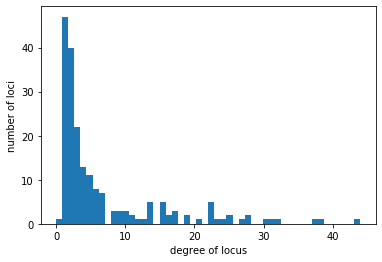

In [120]:
# Distribution of degree
plt.figure()
plt.hist(steiner_tree_nodes_df['degree'], 50)
plt.xlabel('degree of locus')
plt.ylabel('number of loci')
plt.show()

In [121]:
node_attributes.loc['chr_1_loc_143750000']

adhesome_gene_id                                      
tf_gene_id                                            
locus_gene_list             [FAM72D, PPIAL4G, SRGAP2B]
locus_adhesome_gene_list                            []
locus_tf_gene_list                                  []
has_genes                                            3
has_adhesome_genes                                   0
has_tf_genes                                         0
number_DQ                                            0
number_SNORD                                         0
number_MIR                                           0
minus_DQ_SNORD_MIR_genes                             3
Name: chr_1_loc_143750000, dtype: object

# GSEA on genes in Steiner network

### GSEA on all genes in the Steiner network

In [63]:
# Select all genes in Steiner network
print('Number of loci in Steiner network = '+str(len(final_network.nodes)))
final_genes = np.unique(list(itertools.chain.from_iterable(node_attributes.loc[list(final_network.nodes),'locus_gene_list'].values)))
print('Number of final genes = '+str(len(final_genes)))

Number of loci in Steiner network = 198
Number of final genes = 1403


In [64]:
 # Run GSEA
enr = gseapy.enrichr(gene_list=list(final_genes), gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='top_adhesome_hic', outdir='gsea_top_hic',format='png',
                     verbose=False)
print(len(enr.results))

3307


In [65]:
# Visualize results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,cell-matrix adhesion (GO:0007160),22/90,1.817837e-07,0.000452,0,0,4.340823,67.371518,ITGB5;ITGB4;ITGA3;ITGB3;ITGA2;ITGB2;ITGA1;THY1...
1,GO_Biological_Process_2018,integrin-mediated signaling pathway (GO:0007229),17/58,2.736461e-07,0.000452,0,0,5.551191,83.886440,NRP1;ITGB5;SRC;ITGB3;ITGA2;ITGB2;THY1;PTK2;ITG...
2,GO_Biological_Process_2018,ERBB signaling pathway (GO:0038127),18/80,8.243665e-06,0.006594,0,0,3.885292,45.481479,GRB7;PDPK1;SRC;PXN;GAB1;PTPN11;PTPN12;PTK2;CDC...
3,GO_Biological_Process_2018,transmembrane receptor protein tyrosine kinase...,52/396,9.202073e-06,0.006594,0,0,2.042320,23.682911,NRP1;ITGB3;HSPB1;FGF1;AP2A2;ACTB;NCK2;AKT1;ITG...
4,GO_Biological_Process_2018,ephrin receptor signaling pathway (GO:0048013),18/82,1.187546e-05,0.006594,0,0,3.763470,42.681653,SRC;PTPN11;AP2A2;ACTB;RHOA;MYL12A;PTK2;VAV2;TI...


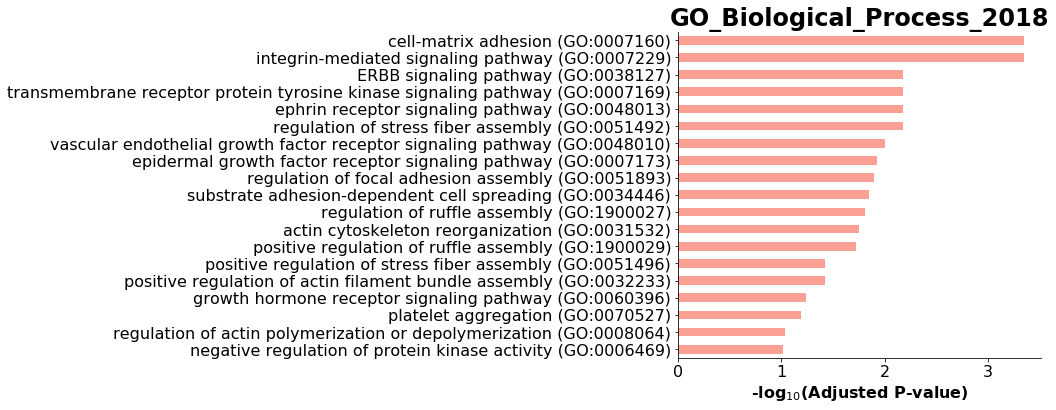

In [66]:
# Barplot
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=0.1, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

### GSEA after removing all adhesome genes

In [67]:
# Remove adhesome genes from the gene set
final_genes_reduced = set(final_genes)-set(all_adhesome_genes)
print('Number of final genes after removing adhesome genes = '+str(len(final_genes_reduced)))

Number of final genes after removing adhesome genes = 1263


In [68]:
# Run GSEA
enr = gseapy.enrichr(gene_list=list(final_genes_reduced), gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='top_adhesome_hic', outdir='gsea_top_hic',format='png',
                     verbose=False)
print(len(enr.results))

2021-04-24 02:50:20,194 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


2759


In [69]:
# Visualize results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,methylation-dependent chromatin silencing (GO:...,4/11,0.003648,0.999996,0,0,8.501078,47.722224,MBD3L4;MBD3L5;MBD3L2;MBD3L3
1,GO_Biological_Process_2018,vacuolar acidification (GO:0007035),5/20,0.006955,0.999996,0,0,4.960784,24.646295,SLC11A1;ATP6V0D1;ATP6V0C;CLN6;ATP6V0A1
2,GO_Biological_Process_2018,regulation of lymphocyte activation (GO:0051249),4/13,0.007140,0.999996,0,0,6.611243,32.673092,KAT2A;SIT1;IKZF3;LAT
3,GO_Biological_Process_2018,folic acid transport (GO:0015884),3/7,0.007253,0.999996,0,0,11.150595,54.930960,FOLR3;FOLR2;FOLR1
4,GO_Biological_Process_2018,dicarboxylic acid transport (GO:0006835),6/29,0.008482,0.999996,0,0,3.883781,18.524689,SLC22A6;SLC26A10;FOLR3;FOLR2;SLC25A22;FOLR1


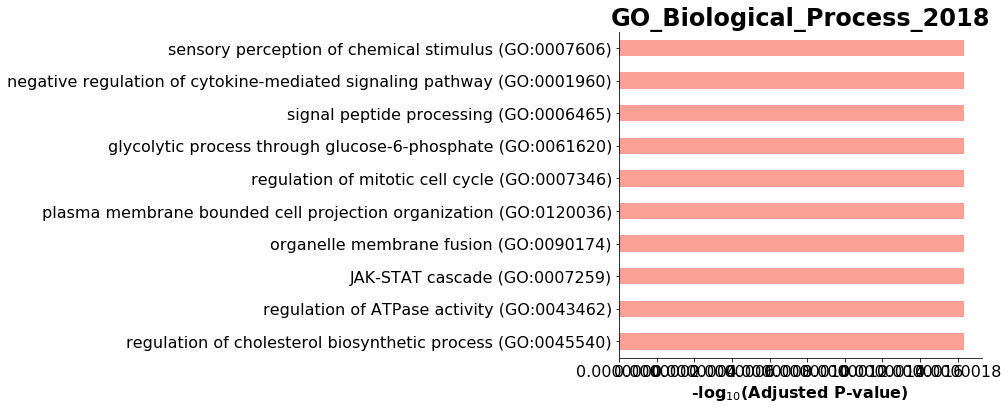

In [70]:
# Barplot
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=1, top_term=10, figsize=(6.5, 6), color='salmon', ofname=None)

### GSEA analysis on genes in Steiner nodes only

In [71]:
# Select genes from non adhesome loci in Steiner tree
steiner_nodes = df_nodes[df_nodes['terminal']==False].index.values
print('Number of Steiner loci in PCSF = '+str(len(steiner_nodes)))
steiner_genes = np.unique(list(itertools.chain.from_iterable(node_attributes.loc[steiner_nodes,'locus_gene_list'].values)))
print('Number of final genes = '+str(len(steiner_genes)))

Number of Steiner loci in PCSF = 38
Number of final genes = 247


In [72]:
# Remove DQ, MIR and SNORD genes
final_steiner_genes = [gene for gene in steiner_genes if ('DQ' not in gene) & ('MIR' not in gene) & ('SNORD' not in gene)]
print('Number of final Steiner genes = '+str(len(final_steiner_genes)))

Number of final Steiner genes = 229


In [73]:
# Show genes
np.array(final_steiner_genes)

array(['AB007962', 'AB074166', 'ABCA2', 'ABCC6P1', 'ABHD16B', 'ACAP3',
       'ACD', 'ADCK5', 'ADRBK2', 'AFG3L1P', 'AGAP6', 'AGRP', 'AK094577',
       'AK127378', 'AK128833', 'AK298596', 'AK302511', 'AK307192',
       'AK309255', 'AK309896', 'AK310441', 'AK311167', 'AK311660',
       'AL137655', 'ANAPC1', 'ANO9', 'ARFRP1', 'ASAH2', 'ASB16', 'ATHL1',
       'ATP6V0D1', 'AX747598', 'B3GALT6', 'B4GALNT4', 'BC000869',
       'BC002534', 'BC031243', 'BC033949', 'BC034020', 'BC034456',
       'BC040735', 'BC065763', 'BC071667', 'BC139719', 'BET1L', 'C16ORF3',
       'C16ORF86', 'C17ORF53', 'C19ORF77', 'C1ORF159', 'C20ORF26', 'C8G',
       'C9ORF139', 'C9ORF142', 'CBWD6', 'CDC16', 'CDC42EP2', 'CEBPB',
       'CELF5', 'CENPBD1', 'CHAMP1', 'CLIC3', 'CPNE1', 'CPSF1', 'CPSF3L',
       'CRYBB2P1', 'CTCF', 'CYHR1', 'DBNDD1', 'DEF8', 'DGAT1', 'DOHH',
       'DPF2', 'DTX2P1-UPK3BP1-PMS2P11', 'DYNLRB1', 'EDF1', 'EDNRB',
       'EEF1D', 'ENKD1', 'ENTPD2', 'FAM132A', 'FAM21A', 'FAM65A',
       'FAM72D',

In [74]:
# Run GSEA
enr = gseapy.enrichr(gene_list=list(final_steiner_genes), gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='top_adhesome_hic', outdir='gsea_top_hic',format='png',
                     verbose=False)
print(len(enr.results))

2021-04-24 02:50:24,910 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


849


In [75]:
# Visualize results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,negative regulation of viral entry into host c...,3/15,0.000609,0.17739,0,0,21.857301,161.828669,IFITM3;IFITM1;IFITM2
1,GO_Biological_Process_2018,protein peptidyl-prolyl isomerization (GO:0000...,4/37,0.000822,0.17739,0,0,10.633266,75.536386,PPIAL4E;PPIAL4D;PPIAL4G;PPIAL4F
2,GO_Biological_Process_2018,response to interferon-alpha (GO:0035455),3/17,0.000895,0.17739,0,0,18.732933,131.486169,IFITM3;IFITM1;IFITM2
3,GO_Biological_Process_2018,peptidyl-proline modification (GO:0018208),4/40,0.001107,0.17739,0,0,9.745679,66.326963,PPIAL4E;PPIAL4D;PPIAL4G;PPIAL4F
4,GO_Biological_Process_2018,negative regulation of sequence-specific DNA b...,7/140,0.001167,0.17739,0,0,4.655761,31.443707,SIGIRR;LRRC14;ITCH;NLRP6;PRMT2;FOXH1;TNFRSF4


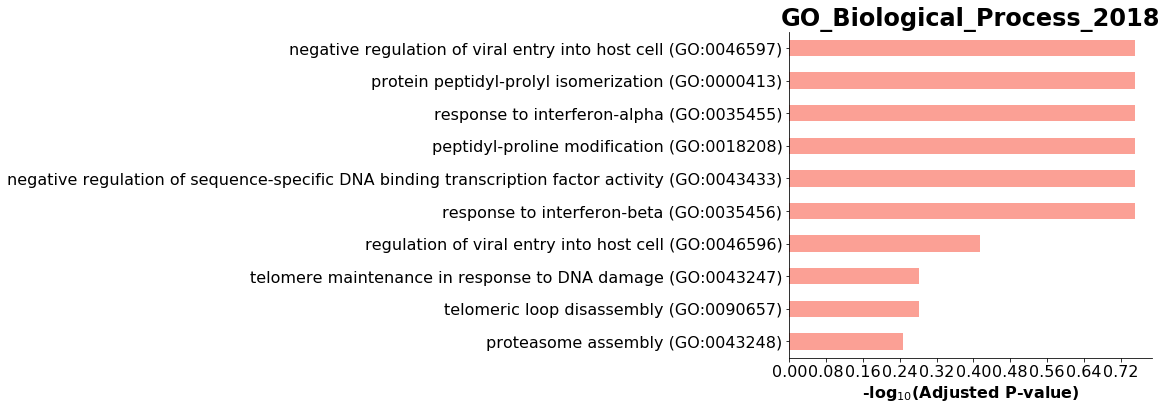

In [76]:
# Barplot
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=1, top_term=10, figsize=(6.5, 6), color='salmon', ofname=None)

# Clustering Steiner network

In [123]:
# Cluster network using Louvain community detection
partition = community.best_partition(final_network, resolution=1, random_state=6)
partition_int = {key: str(val) for i,(key,val) in enumerate(partition.items())}
nx.set_node_attributes(final_network, partition, 'modularity')
nx.set_node_attributes(final_network, partition_int, 'modularity_int')
print('Number of communities = '+str(len(set(partition.values()))))
print('Modularity = '+str(community.modularity(partition,final_network)))
# Save network to html
oi.output_networkx_graph_as_interactive_html(final_network, filename="network_selected_clustered.html")

Number of communities = 8
Modularity = 0.35314341050251474


PosixPath('/home/louiscam/projects/gpcr/code/feedback_loop/network_selected_clustered.html')

# Analyze TFs in network

In [129]:
# List all TFs in the Steiner network
steiner_tf_ls = np.unique(list(itertools.chain.from_iterable(steiner_tree_nodes_df['TF_genes'].values)))
print('Number of unique TFs in PCSF = '+str(len(steiner_tf_ls)))
steiner_tf_ls

Number of unique TFs in PCSF = 46


array(['ABL1', 'CEBPB', 'CREB3', 'CTCF', 'DEAF1', 'DLX3', 'DLX4', 'DNMT1',
       'DRAP1', 'E2F2', 'FOSL1', 'FOXH1', 'FUBP3', 'HAX1', 'HDAC5',
       'HMG20B', 'HSF1', 'ID3', 'ILF3', 'IRF7', 'KDM2A', 'LYL1', 'MAFA',
       'MLX', 'NEAT1', 'NFIC', 'NFIX', 'PCGF2', 'PHB2', 'PHOX2A', 'PIAS3',
       'PPARD', 'RARG', 'RFX1', 'SIRT3', 'SLC2A4RG', 'SP7', 'SPEN',
       'SRCAP', 'STAT3', 'STAT5A', 'STAT5B', 'STAT6', 'TFAP2C', 'TRIP6',
       'ZNF76'], dtype='<U8')

### Analyze these transcription factors

In [130]:
# Load TRRUST data base
trrust_df = pickle.load(open(dir_genome+'trrust_df.pkl', 'rb'))
trrust_df.head()

,TF,Target,Regulation,PMID
0,AATF,BAX,Repression,22909821
1,AATF,CDKN1A,Unknown,17157788
2,AATF,KLK3,Unknown,23146908
3,AATF,MYC,Activation,20549547
4,AATF,TP53,Unknown,17157788


In [131]:
# Look at what TFs regulate adhesome genes
TFs_regulating_adhesome_genes = np.unique(trrust_df[trrust_df['Target'].isin(all_adhesome_genes)]['TF'].values)
print('Number of TFs regulating adhesome genes = '+str(len(np.unique(trrust_df[trrust_df['Target'].isin(all_adhesome_genes)]['TF'].values))))
print('Number of TFs activating adhesome genes = '+str(len(np.unique(trrust_df[trrust_df['Target'].isin(all_adhesome_genes) & (trrust_df['Regulation']=='Activation')]['TF'].values))))
print('Number of TFs repressing adhesome genes = '+str(len(np.unique(trrust_df[trrust_df['Target'].isin(all_adhesome_genes) & (trrust_df['Regulation']=='Repression')]['TF'].values))))
print('Number of TFs with unknown effect on adhesome genes = '+str(len(np.unique(trrust_df[trrust_df['Target'].isin(all_adhesome_genes) & (trrust_df['Regulation']=='Unknown')]['TF'].values))))
print('Total number of TFs = '+str(len(np.unique(trrust_df['TF'].values))))
print('TFs regulating adhesome genes:')
TFs_regulating_adhesome_genes

Number of TFs regulating adhesome genes = 128
Number of TFs activating adhesome genes = 55
Number of TFs repressing adhesome genes = 40
Number of TFs with unknown effect on adhesome genes = 62
Total number of TFs = 795
TFs regulating adhesome genes:


array(['APC', 'AR', 'ATF1', 'ATF2', 'ATM', 'BCL6', 'BRCA1', 'BTG2',
       'CEBPA', 'CEBPB', 'CEBPD', 'CREB1', 'CREB5', 'CTCF', 'CTNNB1',
       'CTNNBIP1', 'DNMT1', 'E2F1', 'E2F3', 'EGR1', 'EPAS1', 'ERG',
       'ESR1', 'ESR2', 'ETS1', 'ETV4', 'EZH2', 'FOS', 'FOSL1', 'FOSL2',
       'FOXF2', 'FOXO3', 'FOXP2', 'GATA6', 'GLI1', 'HDAC1', 'HDGF',
       'HES1', 'HIC1', 'HIF1A', 'HIPK2', 'HLX', 'HMGA1', 'HNF1A', 'HNF4A',
       'HOXA10', 'HOXA7', 'HOXD1', 'HOXD3', 'HSF2', 'IRF1', 'JUN', 'JUND',
       'KAT5', 'KLF10', 'KLF5', 'KLF8', 'MAF', 'MAZ', 'MEIS1', 'MEN1',
       'MTA1', 'MTF1', 'MXD1', 'MYC', 'NAB2', 'NFIC', 'NFKB1', 'NPM1',
       'PARP1', 'PAX5', 'PAX6', 'PGR', 'PIAS3', 'PKNOX1', 'POU2F1',
       'POU5F1', 'PPARA', 'PPARG', 'PTTG1', 'RARA', 'RBPJ', 'REL', 'RELA',
       'REST', 'RFX1', 'RORA', 'RUNX1', 'RUNX3', 'RXRA', 'SALL4', 'SIRT1',
       'SKI', 'SKIL', 'SOX2', 'SOX9', 'SP1', 'SP2', 'SP3', 'SPDEF',
       'SPI1', 'SREBF1', 'SREBF2', 'SRF', 'STAT1', 'STAT3', 'STAT6',
       

In [132]:
# Restrict TRRUST to Steiner TFs
trrust_df = trrust_df[trrust_df['TF'].isin(steiner_tf_ls)]
trrust_df['is_target_adhesome'] = [(trrust_df.iloc[i]['Target'] in all_adhesome_genes) for i in range(len(trrust_df))]
trrust_df.head()

,TF,Target,Regulation,PMID,is_target_adhesome
5,ABL1,BAX,Activation,11753601,False
6,ABL1,BCL2,Repression,11753601,False
7,ABL1,BCL6,Repression,15509806,False
8,ABL1,CCND2,Activation,15509806,False
9,ABL1,CDKN1A,Activation,11753601;9916993,False


In [142]:
# Only select TFs targeting adhesome genes
trrust_df_adhesome = trrust_df[trrust_df['is_target_adhesome']==True]
all_active_adhesome_genes = np.unique(adhesome_chr_loci[adhesome_chr_loci['active']==True]['gene'].values)
trrust_df_adhesome['is_target_active'] = [(target in all_active_adhesome_genes) for target in trrust_df_adhesome['Target'].values]
print('Number of unique TFs in the Steiner network targeting adhesome genes = '+str(len(np.unique(trrust_df_adhesome['TF'].values))))
print('Number of adhesome genes targeted by Steiner TFs = '+str(len(np.unique(trrust_df_adhesome['Target'].values))))
trrust_df_adhesome

Number of unique TFs in the Steiner network targeting adhesome genes = 9
Number of adhesome genes targeted by Steiner TFs = 16


,TF,Target,Regulation,PMID,is_target_adhesome,is_target_active
604,CEBPB,CSRP1,Activation,14522018,True,True
627,CEBPB,INSR,Activation,8288055,True,True
914,CTCF,ASAP2,Unknown,23999061,True,True
1031,DNMT1,CASP8,Repression,20398055,True,True
1939,FOSL1,ITGAV,Repression,23319049,True,True
1940,FOSL1,ITGB3,Repression,23319049,True,True
1943,FOSL1,PLAUR,Unknown,10471035;11234878,True,True
4107,NFIC,ITGA5,Repression,18775869,True,True
4959,PIAS3,STAT3,Unknown,16098628,True,True
5761,RFX1,ITGAL,Unknown,21192791,True,True


In [144]:
# p-value of hypergeometric test for adhesome TF selection in our augmented Steiner tree
ss.hypergeom.sf(k=9, M=795, n=128, N=46, loc=0)

0.19027949930079874

<Figure size 432x288 with 0 Axes>

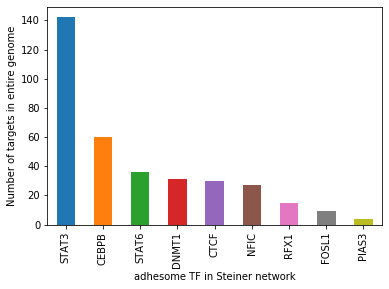

In [182]:
# Plot number of targets of adhesome TFs
plt.figure()
trrust_df[trrust_df['TF'].isin(np.unique(trrust_df_adhesome['TF'].values))].groupby('TF').count().reset_index().sort_values(by='Target', ascending=False).plot.bar(x='TF', y='Target', legend=None)
plt.xlabel('adhesome TF in Steiner network')
plt.ylabel('Number of targets in entire genome')
plt.show()

# Redo Steiner analysis with adhesome loci and adhesome TF loci

In [191]:
# Create a dataframe of adhesome TF loci
df_components_tf = pd.DataFrame({'geneSymbol': TFs_regulating_adhesome_genes})
tf_loc_df,_ = lu.get_adhesome_genes_location(df_components_tf, df_loc)
tf_loc_df = lu.get_adhesome_genes_loci(tf_loc_df, resol)
tf_loc_df['chrom_int'] = tf_loc_df['chrom'].str.split('chr').str[1].astype(int)
tf_genes = np.unique(tf_loc_df['gene'])
print('Final number of TF genes = '+str(len(tf_genes)))
# Construct data frame annotating each TF locus with gene
tf_chr_loci = tf_loc_df[['chrom','chrom_int','loci','gene']]
tf_chr_loci = tf_chr_loci.sort_values(['chrom_int','loci'])
tf_loci = [tf_chr_loci.iloc[i]['chrom']+'_'+'loc'+str(tf_chr_loci.iloc[i]['loci']*resol) 
                 for i in range(len(tf_chr_loci))]
# Add locus ID column
tf_chr_loci['locus_id'] = ['chr_'+str(tf_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(tf_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(tf_chr_loci))]
print('Final number of TF loci = '+str(len(tf_chr_loci)))
tf_chr_loci.head()

Adhesome genes absent from UCSC genes: ['TAF1', 'KLF8', 'AR']
Final number of TF genes = 125
Final number of TF loci = 160


,chrom,chrom_int,loci,gene,locus_id
90,chr1,1,8,SKI,chr_1_loc_2000000
14,chr1,1,39,CTNNBIP1,chr_1_loc_9750000
86,chr1,1,100,RUNX3,chr_1_loc_25000000
86,chr1,1,101,RUNX3,chr_1_loc_25250000
34,chr1,1,131,HDAC1,chr_1_loc_32750000


In [192]:
# Build interactome file
beta = 1
interactome_file_name = "loci_interactome.txt"
interactome_df = oi.get_networkx_graph_as_dataframe_of_edges(G1)
interactome_df['cost'] = np.exp(-beta*interactome_df['hic_contact'])/max(np.exp(-beta*interactome_df['hic_contact']))
interactome_df['normalized_hic'] = interactome_df['hic_contact']/max(interactome_df['hic_contact'])
interactome_df = interactome_df[['protein1','protein2','cost','hic_contact','normalized_hic']]
interactome_df.to_csv(interactome_file_name, sep='\t', header=True, index=False)
# Build prize file
adhesome_loci_G1 = [locus for locus in G1.nodes if (locus in active_adhesome_loci)]
tf_loci_G1 = [locus for locus in G1.nodes if (locus in tf_chr_loci['locus_id'].values)]
print('Number of adhesome loci in G1 = '+str(len(adhesome_loci_G1)))
print('Number of TF loci in G1 = '+str(len(tf_loci_G1)))
prize_file_name = "adhesome_tf_loci_prizes.tsv"
prize_df = pd.DataFrame({'name': adhesome_loci_G1+tf_loci_G1})
prize_df['prize'] = 10
prize_df = prize_df.drop_duplicates()
prize_df.to_csv(prize_file_name, sep='\t', header=True, index=False)
n_terminals = len(prize_df)
len(prize_df)

Number of adhesome loci in G1 = 160
Number of TF loci in G1 = 79


232

In [193]:
# Side note: hypergeometric p-value for selecting 79 TF loci out of 160 when selecting 2733 nodes in G1 
# out of 11,537 nodes in the entire genome
ss.hypergeom.sf(k=79, M=11537, n=160, N=2733, loc=0)

3.2025449138285763e-13

In [194]:
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }
# Set sweeping parameters, i.e. configurations (w,b,g)
G = 0
W_list = np.arange(0.2, 5, 0.2) #np.linspace(start = 0.5, stop = 2, num = 5)
B_list = np.array([10., 20., 30., 40., 50.])
lW = len(W_list)
lB = len(B_list)
N = lW*lB

In [195]:
# Build graph
graph = oi.Graph(interactome_file_name, graph_params)

# Build Steiner trees for different values of W and B, store results in a dictionary
networks_dict = {}
count = 0
for i in np.arange(lW):
    for j in np.arange(lB):
        # Reset parameters
        hyperparams = {"w": W_list[i], 
                       "b": B_list[j], 
                       "g": G,
                       "pruning": 'strong',
                       "edge_noise": 0, 
                       "dummy_mode": "terminals", 
                       "seed": 0, 
                       "skip_checks": False,
                       "verbosity_level": 0}
        graph._reset_hyperparameters(hyperparams)
        graph.prepare_prizes(prize_file_name)
        # Run PCSF
        vertex_indices, edge_indices = graph.pcsf()
        forest, augmented_forest = graph.output_forest_as_networkx(vertex_indices, edge_indices)
        # Store result in network
        key = "w_"+str(W_list[i])+"_b_"+str(B_list[j])
        networks_dict[key] = augmented_forest
        # Print progress
        count = count+1
        print('Progress= '+str(count/N))

04:37:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:23 - OI2: INFO - []
04:37:23 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:23 - OI2: INFO - []
04:37:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:23 - OI2: INFO - []
04:37:23 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:23 - OI2: INFO - []
04:37:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:23 - OI2: INFO - []
04:37:23 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:23 - OI2: INFO - []


Progress= 0.008333333333333333
Progress= 0.016666666666666666


04:37:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:24 - OI2: INFO - []


Progress= 0.025
Progress= 0.03333333333333333


04:37:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:24 - OI2: INFO - []


Progress= 0.041666666666666664
Progress= 0.05


04:37:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:24 - OI2: INFO - []


Progress= 0.058333333333333334
Progress= 0.06666666666666667


04:37:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:24 - OI2: INFO - []
04:37:24 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:24 - OI2: INFO - []
04:37:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:25 - OI2: INFO - []
04:37:25 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:25 - OI2: INFO - []


Progress= 0.075
Progress= 0.08333333333333333


04:37:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:25 - OI2: INFO - []
04:37:25 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:25 - OI2: INFO - []
04:37:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:25 - OI2: INFO - []
04:37:25 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:25 - OI2: INFO - []


Progress= 0.09166666666666666
Progress= 0.1


04:37:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:25 - OI2: INFO - []
04:37:25 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:25 - OI2: INFO - []
04:37:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:25 - OI2: INFO - []
04:37:25 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:25 - OI2: INFO - []


Progress= 0.10833333333333334
Progress= 0.11666666666666667


04:37:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:26 - OI2: INFO - []
04:37:26 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:26 - OI2: INFO - []
04:37:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:26 - OI2: INFO - []
04:37:26 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:26 - OI2: INFO - []


Progress= 0.125


04:37:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:26 - OI2: INFO - []
04:37:26 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:26 - OI2: INFO - []


Progress= 0.13333333333333333


04:37:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:26 - OI2: INFO - []
04:37:26 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:26 - OI2: INFO - []


Progress= 0.14166666666666666


04:37:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:27 - OI2: INFO - []
04:37:27 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:27 - OI2: INFO - []


Progress= 0.15


04:37:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:27 - OI2: INFO - []
04:37:27 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:27 - OI2: INFO - []


Progress= 0.15833333333333333


04:37:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:27 - OI2: INFO - []
04:37:27 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:27 - OI2: INFO - []


Progress= 0.16666666666666666


04:37:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:28 - OI2: INFO - []
04:37:28 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:28 - OI2: INFO - []


Progress= 0.175


04:37:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:28 - OI2: INFO - []
04:37:28 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:28 - OI2: INFO - []


Progress= 0.18333333333333332


04:37:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:28 - OI2: INFO - []
04:37:28 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:28 - OI2: INFO - []


Progress= 0.19166666666666668


04:37:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:29 - OI2: INFO - []
04:37:29 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:29 - OI2: INFO - []


Progress= 0.2


04:37:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:29 - OI2: INFO - []
04:37:29 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:29 - OI2: INFO - []


Progress= 0.20833333333333334


04:37:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:29 - OI2: INFO - []
04:37:29 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:29 - OI2: INFO - []


Progress= 0.21666666666666667


04:37:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:30 - OI2: INFO - []
04:37:30 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:30 - OI2: INFO - []


Progress= 0.225


04:37:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:30 - OI2: INFO - []
04:37:30 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:30 - OI2: INFO - []


Progress= 0.23333333333333334


04:37:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:30 - OI2: INFO - []
04:37:30 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:30 - OI2: INFO - []


Progress= 0.24166666666666667


04:37:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:31 - OI2: INFO - []
04:37:31 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:31 - OI2: INFO - []


Progress= 0.25


04:37:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:31 - OI2: INFO - []
04:37:31 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:31 - OI2: INFO - []


Progress= 0.25833333333333336


04:37:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:31 - OI2: INFO - []
04:37:31 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:31 - OI2: INFO - []


Progress= 0.26666666666666666


04:37:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:32 - OI2: INFO - []
04:37:32 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:32 - OI2: INFO - []


Progress= 0.275


04:37:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:32 - OI2: INFO - []
04:37:32 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:32 - OI2: INFO - []


Progress= 0.2833333333333333


04:37:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:32 - OI2: INFO - []
04:37:32 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:32 - OI2: INFO - []


Progress= 0.2916666666666667


04:37:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:33 - OI2: INFO - []
04:37:33 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:33 - OI2: INFO - []


Progress= 0.3


04:37:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:33 - OI2: INFO - []
04:37:33 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:33 - OI2: INFO - []


Progress= 0.30833333333333335


04:37:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:33 - OI2: INFO - []
04:37:33 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:33 - OI2: INFO - []


Progress= 0.31666666666666665


04:37:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:34 - OI2: INFO - []
04:37:34 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:34 - OI2: INFO - []


Progress= 0.325


04:37:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:34 - OI2: INFO - []
04:37:34 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:34 - OI2: INFO - []


Progress= 0.3333333333333333


04:37:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:34 - OI2: INFO - []
04:37:34 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:34 - OI2: INFO - []


Progress= 0.3416666666666667


04:37:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:35 - OI2: INFO - []
04:37:35 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:35 - OI2: INFO - []


Progress= 0.35


04:37:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:35 - OI2: INFO - []
04:37:35 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:35 - OI2: INFO - []


Progress= 0.35833333333333334


04:37:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:35 - OI2: INFO - []
04:37:35 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:35 - OI2: INFO - []


Progress= 0.36666666666666664


04:37:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:36 - OI2: INFO - []
04:37:36 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:36 - OI2: INFO - []


Progress= 0.375


04:37:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:36 - OI2: INFO - []
04:37:36 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:36 - OI2: INFO - []


Progress= 0.38333333333333336


04:37:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:36 - OI2: INFO - []
04:37:36 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:36 - OI2: INFO - []


Progress= 0.39166666666666666


04:37:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:37 - OI2: INFO - []
04:37:37 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:37 - OI2: INFO - []


Progress= 0.4


04:37:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:37 - OI2: INFO - []
04:37:37 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:37 - OI2: INFO - []


Progress= 0.4083333333333333


04:37:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:37 - OI2: INFO - []
04:37:37 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:37 - OI2: INFO - []


Progress= 0.4166666666666667


04:37:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:38 - OI2: INFO - []
04:37:38 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:38 - OI2: INFO - []


Progress= 0.425


04:37:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:38 - OI2: INFO - []
04:37:38 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:38 - OI2: INFO - []


Progress= 0.43333333333333335


04:37:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:38 - OI2: INFO - []
04:37:38 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:38 - OI2: INFO - []


Progress= 0.44166666666666665


04:37:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:39 - OI2: INFO - []
04:37:39 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:39 - OI2: INFO - []


Progress= 0.45


04:37:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:39 - OI2: INFO - []
04:37:39 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:39 - OI2: INFO - []


Progress= 0.4583333333333333


04:37:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:39 - OI2: INFO - []
04:37:39 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:39 - OI2: INFO - []


Progress= 0.4666666666666667


04:37:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:40 - OI2: INFO - []
04:37:40 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:40 - OI2: INFO - []


Progress= 0.475


04:37:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:40 - OI2: INFO - []
04:37:40 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:40 - OI2: INFO - []


Progress= 0.48333333333333334


04:37:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:41 - OI2: INFO - []
04:37:41 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:41 - OI2: INFO - []


Progress= 0.49166666666666664


04:37:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:41 - OI2: INFO - []
04:37:41 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:41 - OI2: INFO - []


Progress= 0.5


04:37:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:41 - OI2: INFO - []
04:37:41 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:41 - OI2: INFO - []


Progress= 0.5083333333333333


04:37:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:42 - OI2: INFO - []
04:37:42 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:42 - OI2: INFO - []


Progress= 0.5166666666666667


04:37:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:42 - OI2: INFO - []
04:37:42 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:42 - OI2: INFO - []


Progress= 0.525


04:37:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:42 - OI2: INFO - []
04:37:42 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:42 - OI2: INFO - []


Progress= 0.5333333333333333


04:37:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:43 - OI2: INFO - []
04:37:43 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:43 - OI2: INFO - []


Progress= 0.5416666666666666


04:37:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:43 - OI2: INFO - []
04:37:43 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:43 - OI2: INFO - []


Progress= 0.55


04:37:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:43 - OI2: INFO - []
04:37:43 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:43 - OI2: INFO - []


Progress= 0.5583333333333333


04:37:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:44 - OI2: INFO - []
04:37:44 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:44 - OI2: INFO - []


Progress= 0.5666666666666667


04:37:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:44 - OI2: INFO - []
04:37:44 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:44 - OI2: INFO - []


Progress= 0.575


04:37:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:45 - OI2: INFO - []
04:37:45 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:45 - OI2: INFO - []


Progress= 0.5833333333333334


04:37:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:45 - OI2: INFO - []
04:37:45 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:45 - OI2: INFO - []


Progress= 0.5916666666666667


04:37:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:45 - OI2: INFO - []
04:37:45 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:45 - OI2: INFO - []


Progress= 0.6


04:37:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:46 - OI2: INFO - []
04:37:46 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:46 - OI2: INFO - []


Progress= 0.6083333333333333


04:37:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:46 - OI2: INFO - []
04:37:46 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:46 - OI2: INFO - []


Progress= 0.6166666666666667


04:37:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:46 - OI2: INFO - []
04:37:46 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:46 - OI2: INFO - []


Progress= 0.625


04:37:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:47 - OI2: INFO - []
04:37:47 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:47 - OI2: INFO - []


Progress= 0.6333333333333333


04:37:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:47 - OI2: INFO - []
04:37:47 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:47 - OI2: INFO - []


Progress= 0.6416666666666667


04:37:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:47 - OI2: INFO - []
04:37:47 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:47 - OI2: INFO - []


Progress= 0.65


04:37:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:48 - OI2: INFO - []
04:37:48 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:48 - OI2: INFO - []


Progress= 0.6583333333333333


04:37:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:48 - OI2: INFO - []
04:37:48 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:48 - OI2: INFO - []


Progress= 0.6666666666666666


04:37:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:49 - OI2: INFO - []
04:37:49 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:49 - OI2: INFO - []


Progress= 0.675


04:37:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:49 - OI2: INFO - []
04:37:49 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:49 - OI2: INFO - []


Progress= 0.6833333333333333


04:37:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:49 - OI2: INFO - []
04:37:49 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:49 - OI2: INFO - []


Progress= 0.6916666666666667


04:37:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:50 - OI2: INFO - []
04:37:50 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:50 - OI2: INFO - []


Progress= 0.7


04:37:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:50 - OI2: INFO - []
04:37:50 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:50 - OI2: INFO - []


Progress= 0.7083333333333334


04:37:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:50 - OI2: INFO - []
04:37:50 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:50 - OI2: INFO - []


Progress= 0.7166666666666667


04:37:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:51 - OI2: INFO - []
04:37:51 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:51 - OI2: INFO - []


Progress= 0.725


04:37:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:51 - OI2: INFO - []
04:37:51 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:51 - OI2: INFO - []


Progress= 0.7333333333333333


04:37:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:51 - OI2: INFO - []
04:37:51 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:51 - OI2: INFO - []


Progress= 0.7416666666666667


04:37:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:52 - OI2: INFO - []
04:37:52 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:52 - OI2: INFO - []


Progress= 0.75


04:37:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:52 - OI2: INFO - []
04:37:52 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:52 - OI2: INFO - []


Progress= 0.7583333333333333


04:37:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:53 - OI2: INFO - []
04:37:53 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:53 - OI2: INFO - []


Progress= 0.7666666666666667


04:37:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:53 - OI2: INFO - []
04:37:53 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:53 - OI2: INFO - []


Progress= 0.775


04:37:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:53 - OI2: INFO - []
04:37:53 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:53 - OI2: INFO - []


Progress= 0.7833333333333333


04:37:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:54 - OI2: INFO - []
04:37:54 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:54 - OI2: INFO - []


Progress= 0.7916666666666666


04:37:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:54 - OI2: INFO - []
04:37:54 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:54 - OI2: INFO - []


Progress= 0.8


04:37:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:54 - OI2: INFO - []
04:37:54 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:54 - OI2: INFO - []


Progress= 0.8083333333333333


04:37:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:55 - OI2: INFO - []
04:37:55 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:55 - OI2: INFO - []


Progress= 0.8166666666666667


04:37:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:55 - OI2: INFO - []
04:37:55 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:55 - OI2: INFO - []


Progress= 0.825


04:37:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:55 - OI2: INFO - []
04:37:55 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:55 - OI2: INFO - []


Progress= 0.8333333333333334


04:37:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:56 - OI2: INFO - []
04:37:56 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:56 - OI2: INFO - []


Progress= 0.8416666666666667


04:37:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:56 - OI2: INFO - []
04:37:56 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:56 - OI2: INFO - []


Progress= 0.85


04:37:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:56 - OI2: INFO - []
04:37:56 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:56 - OI2: INFO - []


Progress= 0.8583333333333333


04:37:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:57 - OI2: INFO - []
04:37:57 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:57 - OI2: INFO - []


Progress= 0.8666666666666667


04:37:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:57 - OI2: INFO - []
04:37:57 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:57 - OI2: INFO - []


Progress= 0.875


04:37:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:58 - OI2: INFO - []
04:37:58 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:58 - OI2: INFO - []


Progress= 0.8833333333333333


04:37:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:58 - OI2: INFO - []
04:37:58 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:58 - OI2: INFO - []


Progress= 0.8916666666666667


04:37:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:58 - OI2: INFO - []
04:37:58 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:58 - OI2: INFO - []


Progress= 0.9


04:37:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:59 - OI2: INFO - []
04:37:59 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:59 - OI2: INFO - []


Progress= 0.9083333333333333


04:37:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:59 - OI2: INFO - []
04:37:59 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:59 - OI2: INFO - []


Progress= 0.9166666666666666


04:37:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:37:59 - OI2: INFO - []
04:37:59 - OI2: INFO - Members of the prize file not present in the interactome:
04:37:59 - OI2: INFO - []


Progress= 0.925


04:38:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:00 - OI2: INFO - []
04:38:00 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:00 - OI2: INFO - []


Progress= 0.9333333333333333


04:38:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:00 - OI2: INFO - []
04:38:00 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:00 - OI2: INFO - []


Progress= 0.9416666666666667


04:38:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:00 - OI2: INFO - []
04:38:00 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:00 - OI2: INFO - []


Progress= 0.95


04:38:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:01 - OI2: INFO - []
04:38:01 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:01 - OI2: INFO - []


Progress= 0.9583333333333334


04:38:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:01 - OI2: INFO - []
04:38:01 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:01 - OI2: INFO - []


Progress= 0.9666666666666667


04:38:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:01 - OI2: INFO - []
04:38:01 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:01 - OI2: INFO - []


Progress= 0.975


04:38:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:02 - OI2: INFO - []
04:38:02 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:02 - OI2: INFO - []


Progress= 0.9833333333333333


04:38:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:38:02 - OI2: INFO - []
04:38:02 - OI2: INFO - Members of the prize file not present in the interactome:
04:38:02 - OI2: INFO - []


Progress= 0.9916666666666667
Progress= 1.0


In [196]:
# Construct network summary
networks_summary = {}
network_index = 0
for paramstring, network in networks_dict.items():
    if network.number_of_nodes() != 0: 
        network_df = oi.get_networkx_graph_as_dataframe_of_nodes(network)
        networks_summary[paramstring] = {
            "index":                                network_index,
            "w":                                    paramstring.split("_")[1],
            "b":                                    paramstring.split("_")[3],
            "g":                                    0,
            "nodes":                                network.number_of_nodes(),
            "edges":                                network.number_of_edges(),
            "number_components":                    len([c for c in nx.connected_components(network)]),
            "size_components":                      [len(c) for c in sorted(nx.connected_components(network), key=len, reverse=True)],
            "percentage_terminals":                 np.sum(network_df['terminal'])/n_terminals,
        }
        network_index = network_index+1
networks_summary_df = pd.DataFrame.from_dict(networks_summary, orient='index')

<Figure size 432x288 with 0 Axes>

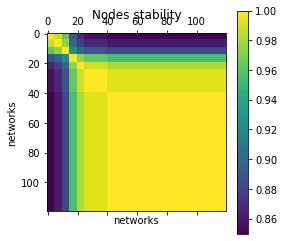

In [162]:
# Loci stability heatmap
N = len(networks_summary_df)
mat_allnodes = np.zeros((N,N))
for i in np.arange(N):
    for j in np.arange(i+1,N,1):
        # Select networks
        paramstring_a = networks_summary_df.loc[networks_summary_df['index']==i].index[0]
        paramstring_b = networks_summary_df.loc[networks_summary_df['index']==j].index[0]
        network_a = networks_dict[paramstring_a]
        network_b = networks_dict[paramstring_b]
        # Compute intersection/union
        intersection = float(len(set(network_a.nodes()).intersection(set(network_b.nodes()))))
        union = float(len(set(network_a.nodes()).union(set(network_b.nodes()))))
        mat_allnodes[i,j] = intersection/union    
mat_allnodes = mat_allnodes+np.transpose(mat_allnodes)+np.diag(np.ones(N))
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

In [197]:
# Summary of that selected network
networks_summary_df.loc['w_3.0000000000000004_b_10.0']

index                                   70
w                       3.0000000000000004
b                                     10.0
g                                        0
nodes                                  273
edges                                  826
number_components                        3
size_components                [271, 1, 1]
percentage_terminals                     1
Name: w_3.0000000000000004_b_10.0, dtype: object

In [198]:
# Select network
final_network = networks_dict['w_3.0000000000000004_b_10.0'].copy()
final_nodes = list(final_network.nodes)

In [199]:
list(nx.connected_components(final_network))[1:3]

[{'chr_8_loc_128500000'}, {'chr_7_loc_6250000'}]

In [200]:
# Add node metadata
nx.set_node_attributes(final_network, {locus: locus.split('_')[1] for locus in final_network.nodes}, 'chromosome')
nx.set_node_attributes(final_network, {locus: float(node_attributes.loc[locus,'minus_DQ_SNORD_MIR_genes']) for locus in final_network.nodes}, 'number_of_genes')
nx.set_node_attributes(final_network, {locus: float(node_attributes.loc[locus,'has_adhesome_genes']) for locus in final_network.nodes}, 'number_of_adhesome_genes')
nx.set_node_attributes(final_network, {locus: float(node_attributes.loc[locus,'has_tf_genes']) for locus in final_network.nodes}, 'number_of_tf_genes')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'has_adhesome_genes']>0) for locus in final_network.nodes}, 'has_adhesome_genes')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'has_tf_genes']>0) for locus in final_network.nodes}, 'has_tf_genes')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'adhesome_gene_id']) for locus in final_network.nodes}, 'adhesome_gene_name')
nx.set_node_attributes(final_network, {locus: str(node_attributes.loc[locus,'tf_gene_id']) for locus in final_network.nodes}, 'tf_gene_name')

In [201]:
# Add node metadata
df_nodes = oi.get_networkx_graph_as_dataframe_of_nodes(final_network)
df_nodes.head()

,prize,terminal,type,degree,betweenness,louvain_clusters,chromosome,number_of_genes,number_of_adhesome_genes,number_of_tf_genes,has_adhesome_genes,has_tf_genes,adhesome_gene_name,tf_gene_name
chr_10_loc_128500000,10.0,True,protein,1,0.000000,2,10,1.0,1.0,0.0,True,False,DOCK1,
chr_10_loc_27000000,10.0,True,protein,2,0.003616,4,10,3.0,1.0,0.0,True,False,ABI1,
chr_10_loc_29500000,10.0,True,protein,1,0.000000,6,10,4.0,1.0,0.0,True,False,SVIL,
chr_10_loc_29750000,10.0,True,protein,3,0.008459,4,10,2.0,1.0,0.0,True,False,SVIL,
chr_10_loc_33250000,10.0,True,protein,1,0.000000,3,10,1.0,1.0,0.0,True,False,NRP1,


In [202]:
# Add edge between contiguous loci on each chromosome
for chrom in np.arange(0,22+1):
    node_chrom_ls = [locus for locus in list(final_network.nodes) if ('chr_'+str(chrom)+'_') in locus]
    node_chrom_pairs = itertools.combinations(node_chrom_ls, 2)
    for pair in node_chrom_pairs:
        locus1, locus2 = pair
        if (abs(int(locus1.split('_')[3])-int(locus2.split('_')[3])) == resol) & ~final_network.has_edge(locus1, locus2):
            final_network.add_edge(locus1, locus2, hic_contact=5, normalized_hic_contact=1, cost=0.005, in_solution=True)

In [203]:
# Edge metadata
df_edges = oi.get_networkx_graph_as_dataframe_of_edges(final_network)
df_edges.head()

,protein1,protein2,in_solution,normalized_hic_contact,hic_contact,normalized_hic,cost
0,chr_15_loc_50750000,chr_1_loc_148000000,NaN,NaN,3.594743,0.476980,0.551711
1,chr_15_loc_50750000,chr_1_loc_149500000,NaN,NaN,3.077024,0.408285,0.925878
2,chr_15_loc_50750000,chr_7_loc_74500000,True,NaN,4.172920,0.553697,0.309465
3,chr_11_loc_65250000,chr_2_loc_87750000,NaN,NaN,3.125541,0.414722,0.882029
4,chr_11_loc_65250000,chr_8_loc_144750000,NaN,NaN,3.199764,0.424571,0.818933


In [204]:
# Save network to html
oi.output_networkx_graph_as_interactive_html(final_network, filename="network_selected_with_tfs.html")

PosixPath('/home/louiscam/projects/gpcr/code/feedback_loop/network_selected_with_tfs.html')

In [205]:
# Cluster network using Louvain community detection
partition = community.best_partition(final_network, resolution=1, random_state=6)
partition_int = {key: str(val) for i,(key,val) in enumerate(partition.items())}
nx.set_node_attributes(final_network, partition, 'modularity')
nx.set_node_attributes(final_network, partition_int, 'modularity_int')
print('Number of communities = '+str(len(set(partition.values()))))
print('Modularity = '+str(community.modularity(partition,final_network)))
# Save network to html
oi.output_networkx_graph_as_interactive_html(final_network, filename="network_selected_with_tfs_clustered.html")

Number of communities = 11
Modularity = 0.3703564754068283


PosixPath('/home/louiscam/projects/gpcr/code/feedback_loop/network_selected_with_tfs_clustered.html')